In [1]:
import netCDF4 as nc
import numpy as np

# Load the data for both years
#data_2020 = nc.Dataset('/Users/heyj/Desktop/sql project/2020data.nc')
#data_2021 = nc.Dataset('/Users/heyj/Desktop/sql project/2020data.nc')
data_2020 = nc.Dataset('2020data.nc')
data_2021 = nc.Dataset('2021data.nc')

# Combine data from both years
z_combined = np.concatenate((data_2020['z'][:], data_2021['z'][:]), axis=0)
u_combined = np.concatenate((data_2020['u'][:], data_2021['u'][:]), axis=0)
v_combined = np.concatenate((data_2020['v'][:], data_2021['v'][:]), axis=0)


In [2]:
# check the dimension
np.info(data_2020['z'][:])


class:  MaskedArray
shape:  (2920, 3, 81, 101)
strides:  (196344, 65448, 808, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f084dbb6010
byteorder:  little
byteswap:  False
type: float64


In [3]:
# check the dimension
np.info(z_combined)

class:  MaskedArray
shape:  (5848, 3, 81, 101)
strides:  (196344, 65448, 808, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f07c4c26010
byteorder:  little
byteswap:  False
type: float64


In [4]:
print("Dimensions:")
for dim in data_2020.dimensions.values():
    print(dim)
    print("\n")


Dimensions:
<class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 101


<class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 81


<class 'netCDF4._netCDF4.Dimension'>: name = 'level', size = 3


<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 2920




In [5]:
# Preprocessing the data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()

z_normalized = scaler.fit_transform(z_combined.reshape(-1, 1)).reshape(z_combined.shape)
u_normalized = scaler.fit_transform(u_combined.reshape(-1, 1)).reshape(u_combined.shape)
v_normalized = scaler.fit_transform(v_combined.reshape(-1, 1)).reshape(v_combined.shape)

# Combine the parameters to form a single dataset
data_combined = np.stack((z_normalized, u_normalized, v_normalized), axis=-1)

# Pad the data to get even dimensions
padded_data = np.pad(data_combined, ((0, 0), (0, 1), (0, 1), (0, 1), (0, 0)), mode='constant')

# Split the data into training and validation sets
X_train_padded, X_val_padded = train_test_split(padded_data, test_size=0.3, shuffle=False)


In [6]:
data_combined.shape


(5848, 3, 81, 101, 3)

In [7]:
np.info(data_combined)

class:  ndarray
shape:  (5848, 3, 81, 101, 3)
strides:  (589032, 196344, 2424, 24, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f062a1f8010
byteorder:  little
byteswap:  False
type: float64


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, UpSampling3D, Add
from tensorflow.keras.models import Model

# Define ResNet block
def resnet_block(input_tensor, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1)):
    x = Conv3D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    x = Conv3D(filters, kernel_size, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    # Adjust the shortcut connection
    if strides != (1, 1, 1) or input_tensor.shape[-1] != filters:
        shortcut = Conv3D(filters, (1, 1, 1), strides=strides, padding='same')(input_tensor)
    else:
        shortcut = input_tensor
    
    x = Add()([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x


# Define the model architecture
input_shape_padded = (4, 82, 102, 3)
inputs = Input(shape=input_shape_padded)

# Encoder
x = resnet_block(inputs, 32)
x = resnet_block(x, 64)
encoded = resnet_block(x, 128, strides=(2, 2, 2))

# Decoder
x = UpSampling3D((2, 2, 2))(encoded)
x = resnet_block(x, 64)
x = UpSampling3D((1, 1, 1))(x)
x = resnet_block(x, 32)
decoded = Conv3D(3, (3, 3, 3), activation='sigmoid', padding='same')(x)

# Compile the autoencoder
autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

In [15]:
# Train the model 
history = autoencoder.fit(X_train_padded, X_train_padded, epochs=20, batch_size=32, validation_data=(X_val_padded, X_val_padded))


Epoch 1/20
128/128 [==============================] - 147s 1s/step - loss: 0.0027 - val_loss: 0.0087
Epoch 2/20
128/128 [==============================] - 146s 1s/step - loss: 1.5343e-04 - val_loss: 0.0103
Epoch 3/20
128/128 [==============================] - 159s 1s/step - loss: 1.2664e-04 - val_loss: 0.0036
Epoch 4/20
128/128 [==============================] - 173s 1s/step - loss: 1.2286e-04 - val_loss: 0.0016
Epoch 5/20
128/128 [==============================] - 176s 1s/step - loss: 9.1917e-05 - val_loss: 4.3607e-04
Epoch 6/20
128/128 [==============================] - 180s 1s/step - loss: 8.9952e-05 - val_loss: 2.6809e-04
Epoch 7/20
128/128 [==============================] - 180s 1s/step - loss: 8.1857e-05 - val_loss: 9.9341e-05
Epoch 8/20
128/128 [==============================] - 183s 1s/step - loss: 8.9129e-05 - val_loss: 2.2549e-04
Epoch 9/20
128/128 [==============================] - 181s 1s/step - loss: 6.7220e-05 - val_loss: 2.6483e-04
Epoch 10/20
128/128 [==================

In [16]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 4, 82, 102,  0                                            
__________________________________________________________________________________________________
conv3d_16 (Conv3D)              (None, 4, 82, 102, 3 2624        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_10 (BatchNo (None, 4, 82, 102, 3 128         conv3d_16[0][0]                  
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 4, 82, 102, 3 0           batch_normalization_10[0][0]     
____________________________________________________________________________________________

In [17]:
# Save Summary text file
original_stdout = sys.stdout  # Save a reference to the original standard output

with open('model_summary.txt', 'w') as f:
    sys.stdout = f  # Change the standard output to the file we created.
    print(autoencoder.summary())
    sys.stdout = original_stdout  # Reset the standard output to its original value




In [9]:
# Save the history object 
import pandas as pd
import pickle

# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save to pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)


In [10]:
# Load the saved history 

loaded_history = pd.read_csv('history.csv')

with open('history.pkl', 'rb') as file:
    loaded_history = pickle.load(file)

In [23]:
# Define the encoder model. Find the low dimension layer according to the model summary. 'activation_15' should be the encoder layer
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('activation_15').output)




NameError: name 'Model' is not defined

In [28]:
from tensorflow.keras.models import load_model

encoder = load_model('/Users/heyj/Desktop/sql project/encoder_yjmodel.h5')

In [19]:
# Save the model
autoencoder.save('autoencoder_yjmodel.h5')

In [21]:
# Save the weights
autoencoder.save_weights('autoencoder_yjweights.h5')  # errrr my weights......

In [28]:
# Save whole training database encoded_database
encoded_database = encoder.predict(X_train_padded)



2023-11-01 04:50:01.331724: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 261.38MiB (rounded to 274071552)requested by op model_3/conv3d_20/Conv3D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-11-01 04:50:01.331848: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2023-11-01 04:50:01.331884: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 274, Chunks in use: 268. 68.5KiB allocated for chunks. 67.0KiB in use in bin. 38.3KiB client-requested in use in bin.
2023-11-01 04:50:01.331909: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (512): 	Total Chunks: 60, Chunks in use: 60. 30.5KiB allocated for chunks. 30.5KiB in use in bin. 29.2KiB client-requested in use in bin.
2023-11-01 0

ResourceExhaustedError:  OOM when allocating tensor with shape[32,64,4,82,102] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model_3/conv3d_20/Conv3D (defined at tmp/ipykernel_24861/441156744.py:23) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_predict_function_25795]

Function call stack:
predict_function


In [24]:
# Load the model
from tensorflow.keras.models import load_model

autoencoder = load_model('autoencoder_yjmodel.h5')

2023-11-03 13:03:38.158172: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Preprocess and Encode the ##Input Day$$ Data, here use 28th Sep 2023 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()

Sep_28_2023 = nc.Dataset('/Users/heyj/Desktop/ARM/Analogue-Nowcasting-Model/Version_01/Sep_24.nc')
#Oct_15_2023 = nc.Dataset('/home/jianhong/Desktop/Analogue-Nowcasting-Model (copy)/15_Oct.nc')
z_input = Sep_28_2023['z'][:]
u_input = Sep_28_2023['u'][:]
v_input = Sep_28_2023['v'][:]

# Normalize the data
scaler = MinMaxScaler()
z_input_normalized = scaler.fit_transform(z_input.reshape(-1, 1)).reshape(z_input.shape)
u_input_normalized = scaler.fit_transform(u_input.reshape(-1, 1)).reshape(u_input.shape)
v_input_normalized = scaler.fit_transform(v_input.reshape(-1, 1)).reshape(v_input.shape)


# Combine the parameters to form a single dataset
data_combined = np.stack((z_input_normalized, u_input_normalized , v_input_normalized), axis=-1)
print(data_combined.shape)

np.info(data_combined)
# Pad the data to get even dimensions
input_day_padded = np.pad(data_combined, ((0, 0), (0, 1), (0, 1), (0, 1), (0, 0)), mode='constant')

# Use the encoder to generate the encoded representation of this input day’s data
input_day_encoded = encoder.predict(input_day_padded)




(8, 3, 81, 101, 3)
class:  ndarray
shape:  (8, 3, 81, 101, 3)
strides:  (589032, 196344, 2424, 24, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fcd2c300000
byteorder:  little
byteswap:  False
type: float64


NameError: name 'encoder' is not defined

In [9]:
# Delete later
np.info(z_input_normalized)

class:  ndarray
shape:  (8, 3, 81, 101)
strides:  (196344, 65448, 808, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fcd2b141000
byteorder:  little
byteswap:  False
type: float64


In [44]:
data_combined = np.concatenate((z_input_normalized, u_input_normalized , v_input_normalized), axis=0)
data_combined = np.moveaxis(data_combined,0,-1)
print(data_combined.shape)

(3, 81, 101, 24)


In [34]:
config = encoder.get_config()
print(config['layers'][0]['config']['batch_input_shape'])

(None, 4, 82, 102, 3)


In [36]:
print(input_day_encoded.shape)

(8, 2, 41, 51, 128)


In [29]:
# Calculate similarities and find the most similar day:

# Use <Euclidean distances> to calculate the Euclidean distances between the input day's encoded representation and the encoded representations of all the days in the database.

from sklearn.metrics.pairwise import euclidean_distances
import numpy as np


# Calculate Euclidean distances 
distances = euclidean_distances(input_day_encoded, encoded_database)

# Find the index of the most similar day (smallest distance)
most_similar_day_index = np.argmin(distances)

# Retrieve the data of the most similar day
most_similar_day_data = original_data_library[most_similar_day_index]







NameError: name 'encoded_database' is not defined

TypeError: Invalid shape (3, 3, 32) for image data

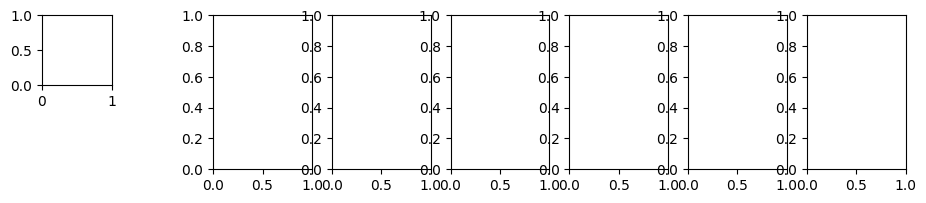

In [19]:
# This part for model interpretation 

# 1. Visualise Filters
import matplotlib.pyplot as plt

filters = autoencoder.layers[1].get_weights()[0]

# Assuming the filters are 3D
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 8
fig, axes = plt.subplots(1, n_filters, figsize=(12,2))
axes = axes.ravel()

for i in range(n_filters):
    f = filters[:, :, :, i]
    plt.subplot(2, 4, i+1)
    plt.imshow(f[:, :, 0], cmap='gray')  # Adjust the last index if needed
    plt.axis('off')

plt.tight_layout()
plt.show()


TypeError: Invalid shape (4, 82, 32) for image data

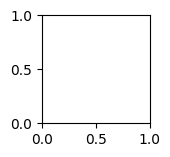

In [30]:
# 2. Visualizing Activations

from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Select a sample from your dataset
sample = X_train_padded[10]
sample = np.expand_dims(sample, axis=0)

# Define a model to fetch activations
activations_model = Model(inputs=autoencoder.input, outputs=[layer.output for layer in autoencoder.layers])
activations = activations_model.predict(sample)

# Visualize activations of the first convolutional layer
first_layer_activations = activations[1]
n_filters = first_layer_activations.shape[-1]

for i in range(n_filters):
    plt.subplot(2, 4, i+1)
    plt.imshow(first_layer_activations[0, :, :, i], cmap='gray')
    plt.axis('off')
plt.show()


TypeError: Invalid shape (2, 41, 128) for image data

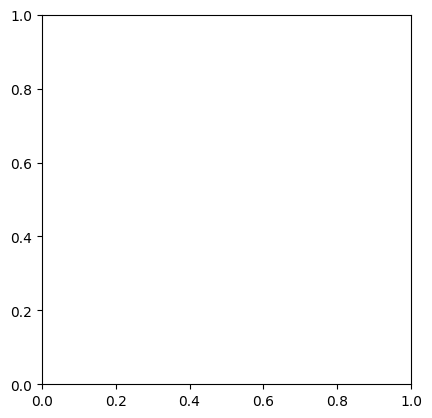

In [34]:
# 3. Visualizing Encoded Representations


encoded_representation = encoder.predict(sample)

plt.imshow(encoded_representation[0, :, :, 0], cmap='gray')  # Adjust indices as needed
plt.title('Encoded Representation')
plt.axis('off')
plt.show()


In [35]:
# 4. Dimensionality Reduction on Encoded Representations (Optional)

from sklearn.manifold import TSNE
import seaborn as sns

# Assuming `encoded_data` contains encoded representations of your entire dataset
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_data.reshape(len(encoded_data), -1))

sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], alpha=0.5)
plt.title('t-SNE of Encoded Representations')
plt.show()


NameError: name 'encoded_data' is not defined

In [ ]:
# Evaluation Part Below


In [36]:
# 1. Reconstruction Error:Evaluate how well the autoencoder can reconstruct the input data

from sklearn.metrics import mean_squared_error, mean_absolute_error

decoded_val = autoencoder.predict(X_val_padded)

# Mean Squared Error (MSE)
mse = mean_squared_error(X_val_padded.flatten(), decoded_val.flatten())

# Mean Absolute Error (MAE)
mae = mean_absolute_error(X_val_padded.flatten(), decoded_val.flatten())

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)


Mean Squared Error: 0.0001398247685000497
Mean Absolute Error: 0.008009587552588803


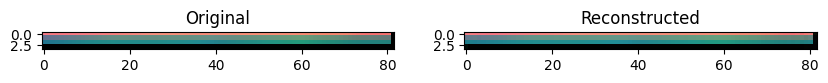

In [37]:
# 2. Visual Inspection of Reconstructions:

import matplotlib.pyplot as plt
import numpy as np

index = np.random.randint(X_val_padded.shape[0])
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(X_val_padded[index, :, :, 0], cmap='gray')  # Adjust indexing if necessary
plt.title('Original')

plt.subplot(1, 2, 2)
plt.imshow(decoded_val[index, :, :, 0], cmap='gray')
plt.title('Reconstructed')

plt.show()


In [38]:
# 3. Latent Space Visualization:

from sklearn.manifold import TSNE
import seaborn as sns


encoded_data = encoder.predict(X_val_padded)

tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(encoded_data.reshape(len(encoded_data), -1))

sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], alpha=0.5)
plt.title('t-SNE of Encoded Representations')
plt.show()
